# Practica 4, Equipo 9

#Problematica

En esta práctica se aborda una problemática de negocio relacionada con la predicción del abandono de clientes (churn) en una empresa de telecomunicaciones, utilizando técnicas de modelación supervisada y análisis exploratorio de datos.

## 0. Importacion de Modulos

In [1]:
import sys
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
from datetime import datetime # pip install xlrd
import seaborn as sns
from io import StringIO
import pydotplus
from IPython.display import Image
# Preprocessing
from sklearn.preprocessing import OneHotEncoder
# Model performance
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay,roc_auc_score, f1_score

# Modeling
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression,Lasso,SGDClassifier,ElasticNet,Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree


## 1. Data Wrangling

In [2]:
def freq_discrete(df, features):
    """
    Calcula y muestra tablas de frecuencias absolutas, relativas y acumuladas para variables categóricas.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame que contiene las variables a analizar.
    features : list of str
        Lista con los nombres de las columnas categóricas a analizar.

    Descripción
    -----------
    Para cada variable en `features`, imprime su nombre y muestra una tabla con:
      - Frecuencia absoluta de cada categoría.
      - Frecuencia relativa (porcentaje) de cada categoría.
      - Frecuencia absoluta acumulada.
      - Frecuencia relativa acumulada.
    Los valores se formatean para mejor visualización.

    Ejemplo
    -------
    freq_discrete(df, ["color", "country"])
    """
    for feature in features:
        print(f"Feature: {feature}")
        abs_series = df[feature].value_counts(dropna=False)
        rel_series = df[feature].value_counts(dropna=False, normalize=True)
        freq = pd.DataFrame({"Absolute frequency": abs_series, "Relative frequency": rel_series})
        freq["Accumulated frequency"] = freq["Absolute frequency"].cumsum()
        freq["Accumulated %"] = freq["Relative frequency"].cumsum()
        freq["Absolute frequency"] = freq["Absolute frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Relative frequency"] = freq["Relative frequency"].map(lambda x: "{:,.2%}".format(x))
        freq["Accumulated frequency"] = freq["Accumulated frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Accumulated %"] = freq["Accumulated %"].map(lambda x: "{:,.2%}".format(x))
        display(freq)

### 1.1 Carga de datos

In [3]:
import pandas as pd
import numpy as np
import sys

# Instalamos motores de lectura por si faltan
!{sys.executable} -m pip install xlrd openpyxl

ruta_original = 'data/WA_Fn-UseC_-Telco-Customer-Churn.xls'
ruta_csv = 'data/Telco_Churn.csv'

try:
    # Intento 1: Leer como Excel estándar
    df = pd.read_excel(ruta_original, engine='xlrd')
except:
    # Intento 2: Si el .xls es en realidad un CSV disfrazado
    df = pd.read_csv(ruta_original)

# Guardar como CSV real para evitar problemas futuros
df.to_csv(ruta_csv, index=False)
print(" Archivo cargado y convertido a CSV correctamente.")
df.head()

 Archivo cargado y convertido a CSV correctamente.



[notice] A new release of pip available: 22.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.2 Limpieza de datos

In [4]:

freq_discrete(df,df.columns)

Feature: customerID


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
customerID,,,,
7590-VHVEG,1,0.01%,1,0.01%
3791-LGQCY,1,0.01%,2,0.03%
6008-NAIXK,1,0.01%,3,0.04%
5956-YHHRX,1,0.01%,4,0.06%
5365-LLFYV,1,0.01%,5,0.07%
...,...,...,...,...
9796-MVYXX,1,0.01%,"7,039",99.94%
2637-FKFSY,1,0.01%,"7,040",99.96%
1552-AAGRX,1,0.01%,"7,041",99.97%


Feature: gender


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
gender,,,,
Male,"3,555",50.48%,"3,555",50.48%
Female,"3,488",49.52%,"7,043",100.00%


Feature: SeniorCitizen


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
SeniorCitizen,,,,
0,"5,901",83.79%,"5,901",83.79%
1,"1,142",16.21%,"7,043",100.00%


Feature: Partner


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
Partner,,,,
No,"3,641",51.70%,"3,641",51.70%
Yes,"3,402",48.30%,"7,043",100.00%


Feature: Dependents


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
Dependents,,,,
No,"4,933",70.04%,"4,933",70.04%
Yes,"2,110",29.96%,"7,043",100.00%


Feature: tenure


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
tenure,,,,
1,613,8.70%,613,8.70%
72,362,5.14%,975,13.84%
2,238,3.38%,"1,213",17.22%
3,200,2.84%,"1,413",20.06%
4,176,2.50%,"1,589",22.56%
...,...,...,...,...
28,57,0.81%,"6,875",97.61%
39,56,0.80%,"6,931",98.41%
44,51,0.72%,"6,982",99.13%


Feature: PhoneService


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
PhoneService,,,,
Yes,"6,361",90.32%,"6,361",90.32%
No,682,9.68%,"7,043",100.00%


Feature: MultipleLines


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
MultipleLines,,,,
No,"3,390",48.13%,"3,390",48.13%
Yes,"2,971",42.18%,"6,361",90.32%
No phone service,682,9.68%,"7,043",100.00%


Feature: InternetService


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
InternetService,,,,
Fiber optic,"3,096",43.96%,"3,096",43.96%
DSL,"2,421",34.37%,"5,517",78.33%
No,"1,526",21.67%,"7,043",100.00%


Feature: OnlineSecurity


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
OnlineSecurity,,,,
No,"3,498",49.67%,"3,498",49.67%
Yes,"2,019",28.67%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: OnlineBackup


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
OnlineBackup,,,,
No,"3,088",43.84%,"3,088",43.84%
Yes,"2,429",34.49%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: DeviceProtection


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
DeviceProtection,,,,
No,"3,095",43.94%,"3,095",43.94%
Yes,"2,422",34.39%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: TechSupport


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
TechSupport,,,,
No,"3,473",49.31%,"3,473",49.31%
Yes,"2,044",29.02%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: StreamingTV


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
StreamingTV,,,,
No,"2,810",39.90%,"2,810",39.90%
Yes,"2,707",38.44%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: StreamingMovies


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
StreamingMovies,,,,
No,"2,785",39.54%,"2,785",39.54%
Yes,"2,732",38.79%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: Contract


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
Contract,,,,
Month-to-month,"3,875",55.02%,"3,875",55.02%
Two year,"1,695",24.07%,"5,570",79.09%
One year,"1,473",20.91%,"7,043",100.00%


Feature: PaperlessBilling


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
PaperlessBilling,,,,
Yes,"4,171",59.22%,"4,171",59.22%
No,"2,872",40.78%,"7,043",100.00%


Feature: PaymentMethod


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
PaymentMethod,,,,
Electronic check,"2,365",33.58%,"2,365",33.58%
Mailed check,"1,612",22.89%,"3,977",56.47%
Bank transfer (automatic),"1,544",21.92%,"5,521",78.39%
Credit card (automatic),"1,522",21.61%,"7,043",100.00%


Feature: MonthlyCharges


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
MonthlyCharges,,,,
20.05,61,0.87%,61,0.87%
19.85,45,0.64%,106,1.51%
19.95,44,0.62%,150,2.13%
19.90,44,0.62%,194,2.75%
20.00,43,0.61%,237,3.37%
...,...,...,...,...
23.65,1,0.01%,"7,039",99.94%
114.70,1,0.01%,"7,040",99.96%
43.65,1,0.01%,"7,041",99.97%


Feature: TotalCharges


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
TotalCharges,,,,
,11,0.16%,11,0.16%
20.2,11,0.16%,22,0.31%
19.75,9,0.13%,31,0.44%
20.05,8,0.11%,39,0.55%
19.9,8,0.11%,47,0.67%
...,...,...,...,...
6849.4,1,0.01%,"7,039",99.94%
692.35,1,0.01%,"7,040",99.96%
130.15,1,0.01%,"7,041",99.97%


Feature: Churn


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
Churn,,,,
No,"5,174",73.46%,"5,174",73.46%
Yes,"1,869",26.54%,"7,043",100.00%


In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# 1. Aseguramos que TotalCharges sea numérico (corrigiendo errores de la imagen)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Eliminación de nulos (generados por espacios vacíos en TotalCharges)
df.dropna(subset=['TotalCharges'], inplace=True)

# 3. Exportar a CSV para estandarizar el flujo de trabajo del equipo
df.to_csv('data/Telco_Churn_Clean.csv', index=False)
print(" Datos limpios y exportados a 'data/Telco_Churn_Clean.csv'")

 Datos limpios y exportados a 'data/Telco_Churn_Clean.csv'


### INSIGHT 1: La antigüedad del cliente (Tenure) frente al abandono

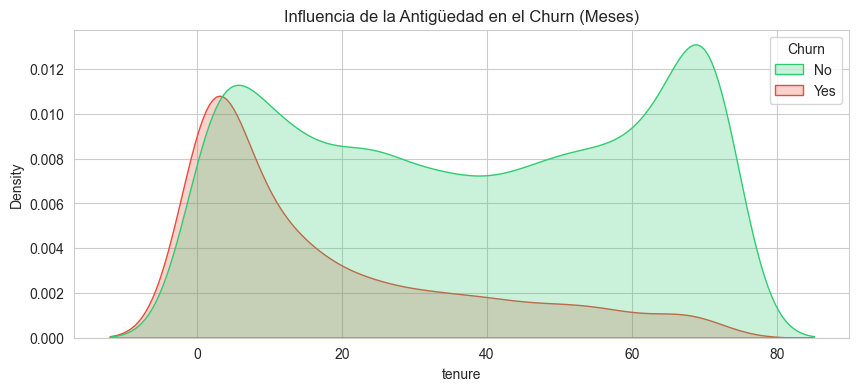

In [8]:
# Configuración estética
sns.set_style("whitegrid")
palette_churn = {"Yes": "#E74C3C", "No": "#2ECC71"}

plt.figure(figsize=(10, 4))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, palette=palette_churn)
plt.title('Influencia de la Antigüedad en el Churn (Meses)')
plt.show()

### INSIGHT 2: Contratos mes a mes 

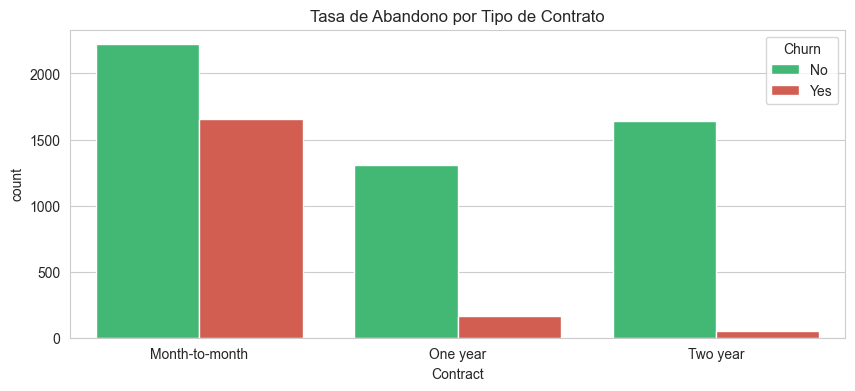

In [9]:

plt.figure(figsize=(10, 4))
contract_order = ['Month-to-month', 'One year', 'Two year']
sns.countplot(data=df, x='Contract', hue='Churn', order=contract_order, palette=palette_churn)
plt.title('Tasa de Abandono por Tipo de Contrato')
plt.show()

### INSIGHT 3: Cargos mensuales altos 

C:\Users\casti\AppData\Local\Temp\ipykernel_21984\1463690656.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=palette_churn)


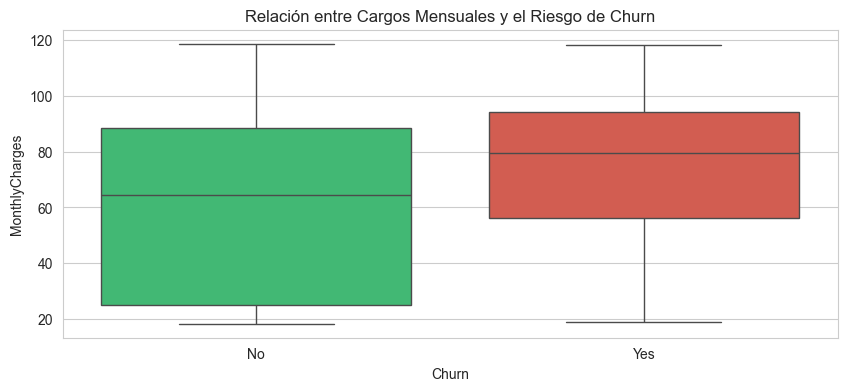

In [10]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=palette_churn)
plt.title('Relación entre Cargos Mensuales y el Riesgo de Churn')
plt.show()

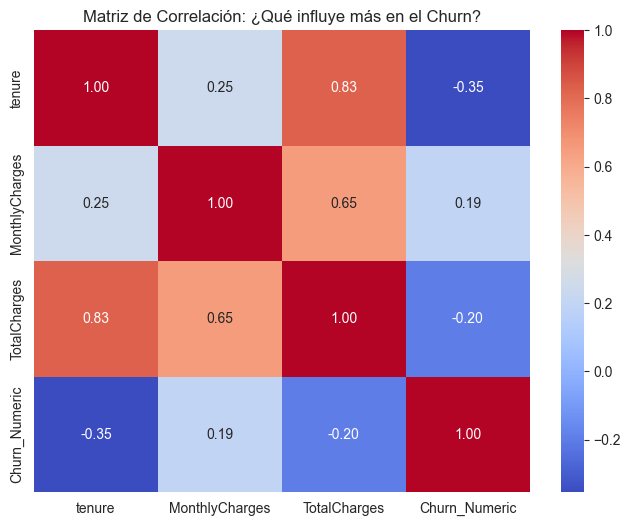

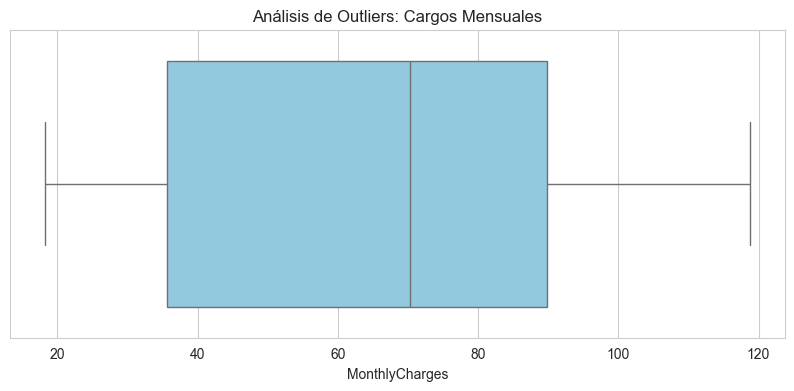

In [11]:
# 1. Preparación para correlación: Convertir Churn a binario (0 y 1)
df_corr = df.copy()
df_corr['Churn_Numeric'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# 2. Matriz de Correlación (Solo variables clave)
plt.figure(figsize=(8, 6))
cols_interes = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Numeric']
sns.heatmap(df_corr[cols_interes].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación: ¿Qué influye más en el Churn?')
plt.show()

# 3. Detección de Outliers en Cargos Mensuales
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MonthlyCharges'], color='skyblue')
plt.title('Análisis de Outliers: Cargos Mensuales')
plt.show()

### INSIGHT 4: Servicios adicionales reducen el churn, fortaleciendo la lealtad y el ticket promedio


💡 Porcentaje de Churn según OnlineSecurity:



,% Churn
OnlineSecurity,
No,41.78%
Yes,14.64%
No internet service,7.43%


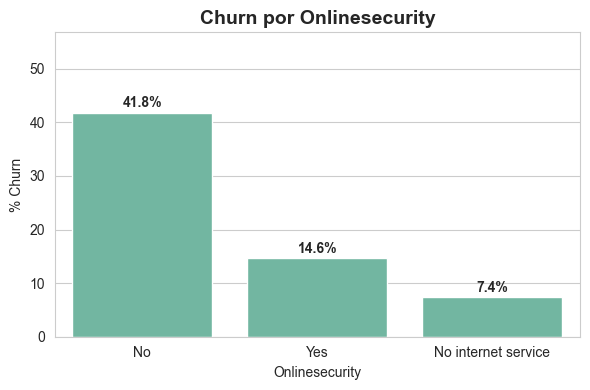


💡 Porcentaje de Churn según OnlineBackup:



,% Churn
OnlineBackup,
No,39.94%
Yes,21.57%
No internet service,7.43%


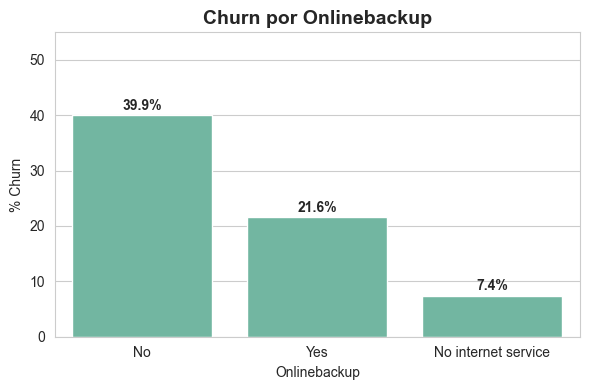


💡 Porcentaje de Churn según DeviceProtection:



,% Churn
DeviceProtection,
No,39.14%
Yes,22.54%
No internet service,7.43%


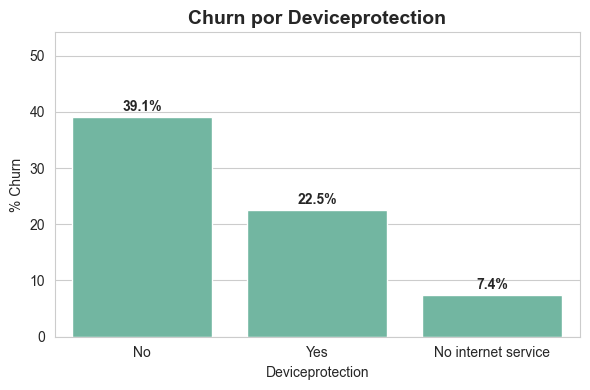


💡 Porcentaje de Churn según TechSupport:



,% Churn
TechSupport,
No,41.65%
Yes,15.20%
No internet service,7.43%


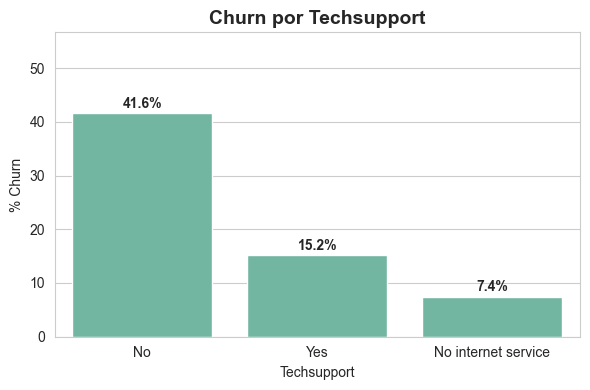


💡 Porcentaje de Churn según StreamingTV:



,% Churn
StreamingTV,
No,33.54%
Yes,30.11%
No internet service,7.43%


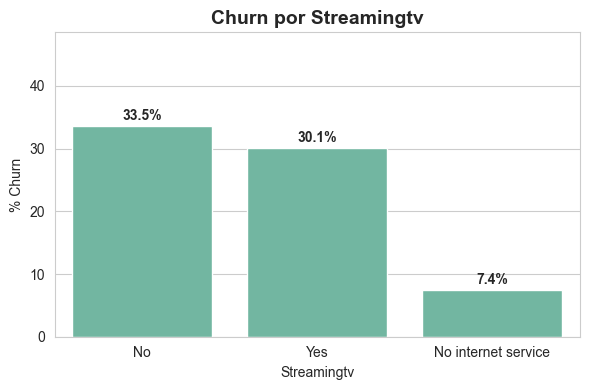


💡 Porcentaje de Churn según StreamingMovies:



,% Churn
StreamingMovies,
No,33.73%
Yes,29.95%
No internet service,7.43%


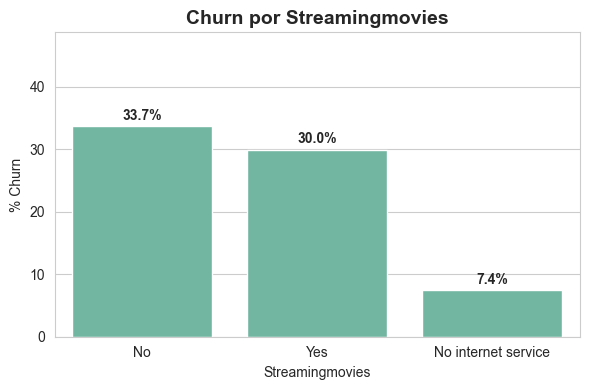

In [12]:
sns.set_style("whitegrid")
sns.set_palette("Set2")

servicios = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']

for s in servicios:

    churn_pct = df.groupby(s)['Churn'].value_counts(normalize=True).unstack()['Yes']*100
    churn_pct = churn_pct.sort_values(ascending=False)  # Ordenar de mayor a menor churn
    print(f"\n💡 Porcentaje de Churn según {s}:\n")
    display(churn_pct.to_frame(name='% Churn').style.format("{:.2f}%"))


    plt.figure(figsize=(6,4))
    ax = sns.barplot(x=churn_pct.index, y=churn_pct.values)
    
    for i, v in enumerate(churn_pct.values):
        ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
    
    plt.ylabel('% Churn')
    plt.xlabel(s.replace('_',' ').title())
    plt.title(f'Churn por {s.replace("_"," ").title()}', fontsize=14, fontweight='bold')
    plt.ylim(0, churn_pct.values.max() + 15)
    plt.tight_layout()
    plt.show()

,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Churn
OnlineSecurity_No,1.00,-0.52,-0.63,0.38,-0.52,0.06,0.37,-0.52,0.06,0.47,-0.52,-0.04,0.26,-0.52,0.18,0.27,-0.52,0.17,0.34
OnlineSecurity_No internet service,-0.52,1.00,-0.33,-0.46,1.00,-0.38,-0.47,1.00,-0.38,-0.52,1.00,-0.34,-0.43,1.00,-0.41,-0.42,1.00,-0.42,-0.23
OnlineSecurity_Yes,-0.63,-0.33,1.00,0.00,-0.33,0.28,0.01,-0.33,0.27,-0.05,-0.33,0.35,0.11,-0.33,0.18,0.09,-0.33,0.19,-0.17
OnlineBackup_No,0.38,-0.46,0.00,1.00,-0.46,-0.64,0.36,-0.46,0.03,0.39,-0.46,-0.00,0.32,-0.46,0.07,0.31,-0.46,0.08,0.27
OnlineBackup_No internet service,-0.52,1.00,-0.33,-0.46,1.00,-0.38,-0.47,1.00,-0.38,-0.52,1.00,-0.34,-0.43,1.00,-0.41,-0.42,1.00,-0.42,-0.23
OnlineBackup_Yes,0.06,-0.38,0.28,-0.64,-0.38,1.00,0.03,-0.38,0.30,0.05,-0.38,0.29,0.04,-0.38,0.28,0.05,-0.38,0.27,-0.08
DeviceProtection_No,0.37,-0.47,0.01,0.36,-0.47,0.03,1.00,-0.47,-0.64,0.42,-0.47,-0.04,0.42,-0.47,-0.03,0.43,-0.47,-0.04,0.25
DeviceProtection_No internet service,-0.52,1.00,-0.33,-0.46,1.00,-0.38,-0.47,1.00,-0.38,-0.52,1.00,-0.34,-0.43,1.00,-0.41,-0.42,1.00,-0.42,-0.23
DeviceProtection_Yes,0.06,-0.38,0.27,0.03,-0.38,0.30,-0.64,-0.38,1.00,0.01,-0.38,0.33,-0.07,-0.38,0.39,-0.08,-0.38,0.40,-0.07
TechSupport_No,0.47,-0.52,-0.05,0.39,-0.52,0.05,0.42,-0.52,0.01,1.00,-0.52,-0.63,0.35,-0.52,0.09,0.35,-0.52,0.09,0.34


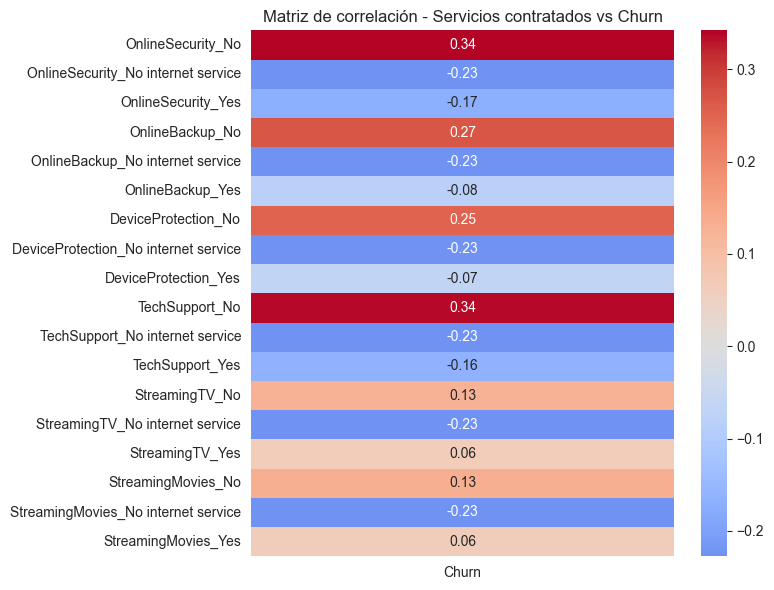

In [13]:
df_services = df[servicios + ['Churn']].copy()

df_encoded = pd.get_dummies(
    df_services,
    columns=servicios,
    drop_first=False
)
df_encoded.head()

df_encoded['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = pd.get_dummies(df[servicios], drop_first=False).astype(int)
y = df['Churn'].map({'Yes': 1, 'No': 0})
corr_matrix = pd.concat([X, y], axis=1).corr()
display(corr_matrix.style.format("{:.2f}"))
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix.loc[X.columns, ['Churn']],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True
)
plt.title("Matriz de correlación - Servicios contratados vs Churn")
plt.tight_layout()
plt.show()

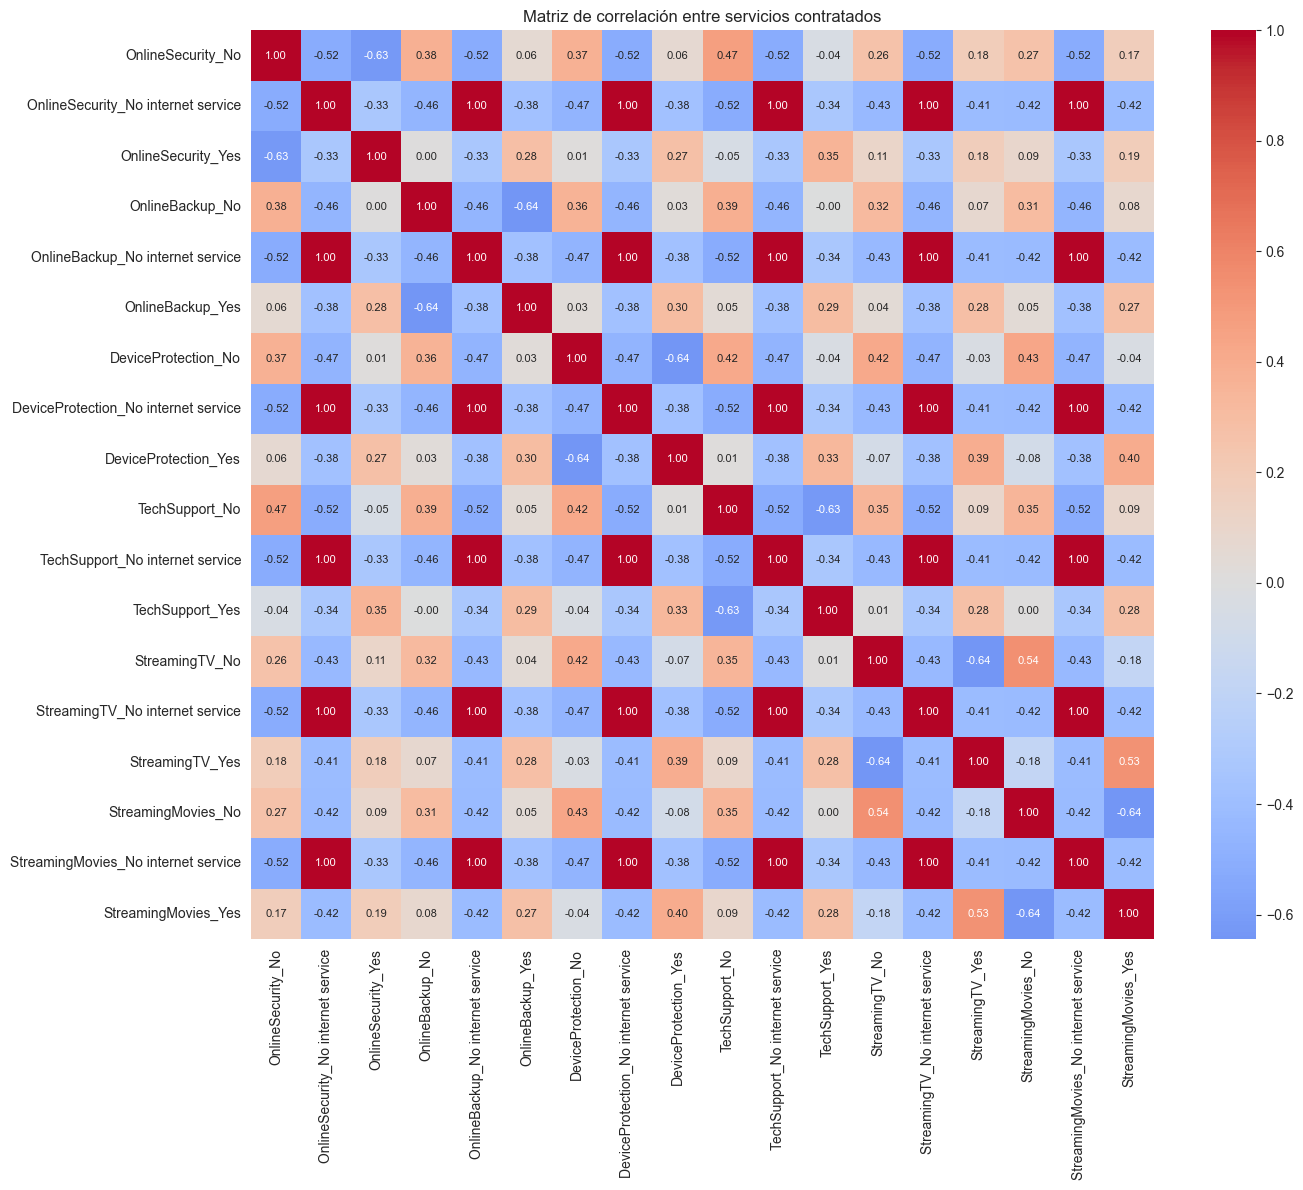

In [14]:
X = pd.get_dummies(df[servicios], drop_first=False).astype(int)

# Matriz de correlación
corr_services = X.corr()

# Heatmap con valores
plt.figure(figsize=(14,12))
sns.heatmap(
    corr_services,
    annot=True,       
    fmt=".2f",           
    cmap="coolwarm",
    center=0,
    cbar=True,
    annot_kws={"size":8}
)

plt.title("Matriz de correlación entre servicios contratados")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

El análisis de los servicios contratados muestra que los clientes que no tienen activados servicios complementarios, como seguridad en línea, 
soporte técnico, respaldo de datos o servicios de streaming, presentan una mayor probabilidad de abandonar la compañía. 
En particular, los servicios relacionados con la seguridad y el soporte tienen un efecto más fuerte en la retención, mientras que los servicios de entretenimiento ayudan,
pero en menor medida. Esto indica que ofrecer y fomentar la contratación de estos servicios puede ser una estrategia efectiva para reducir el churn y 
mejorar la fidelidad de los clientes.

### INSIGHT 5: -El método de pago influye en el comportamiento de churn

In [15]:
df_pay = df[['PaymentMethod', 'Churn']].copy()
df_pay['Churn'] = df_pay['Churn'].map({'Yes': 1, 'No': 0})

df_encoded = pd.get_dummies(
    df_pay,
    columns=['PaymentMethod'],
    drop_first=False
).astype(int)


distribucion_pago = (
    df_pay
    .groupby('PaymentMethod')['Churn']
    .mean()
    .sort_values(ascending=False) * 100
)

print("Tasa de Churn por método de pago (%):\n")
display(distribucion_pago.to_frame(name='Churn_%'))

Tasa de Churn por método de pago (%):



,Churn_%
PaymentMethod,
Electronic check,45.285412
Mailed check,19.201995
Bank transfer (automatic),16.731518
Credit card (automatic),15.253123


,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
PaymentMethod_Bank transfer (automatic),1.00,-0.28,-0.38,-0.29,-0.12
PaymentMethod_Credit card (automatic),-0.28,1.00,-0.37,-0.29,-0.13
PaymentMethod_Electronic check,-0.38,-0.37,1.00,-0.39,0.30
PaymentMethod_Mailed check,-0.29,-0.29,-0.39,1.00,-0.09
Churn,-0.12,-0.13,0.30,-0.09,1.00


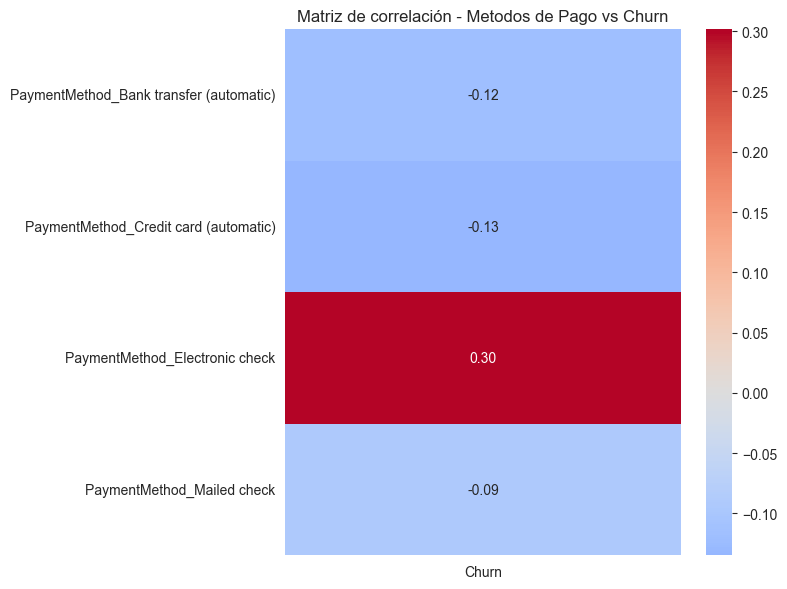

In [16]:

X = df_encoded[['PaymentMethod_Bank transfer (automatic)','PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']]
y = df['Churn'].map({'Yes': 1, 'No': 0})
corr_matrix = pd.concat([X, y], axis=1).corr()
display(corr_matrix.style.format("{:.2f}"))
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix.loc[X.columns, ['Churn']],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True
)
plt.title("Matriz de correlación - Metodos de Pago vs Churn")
plt.tight_layout()
plt.show()

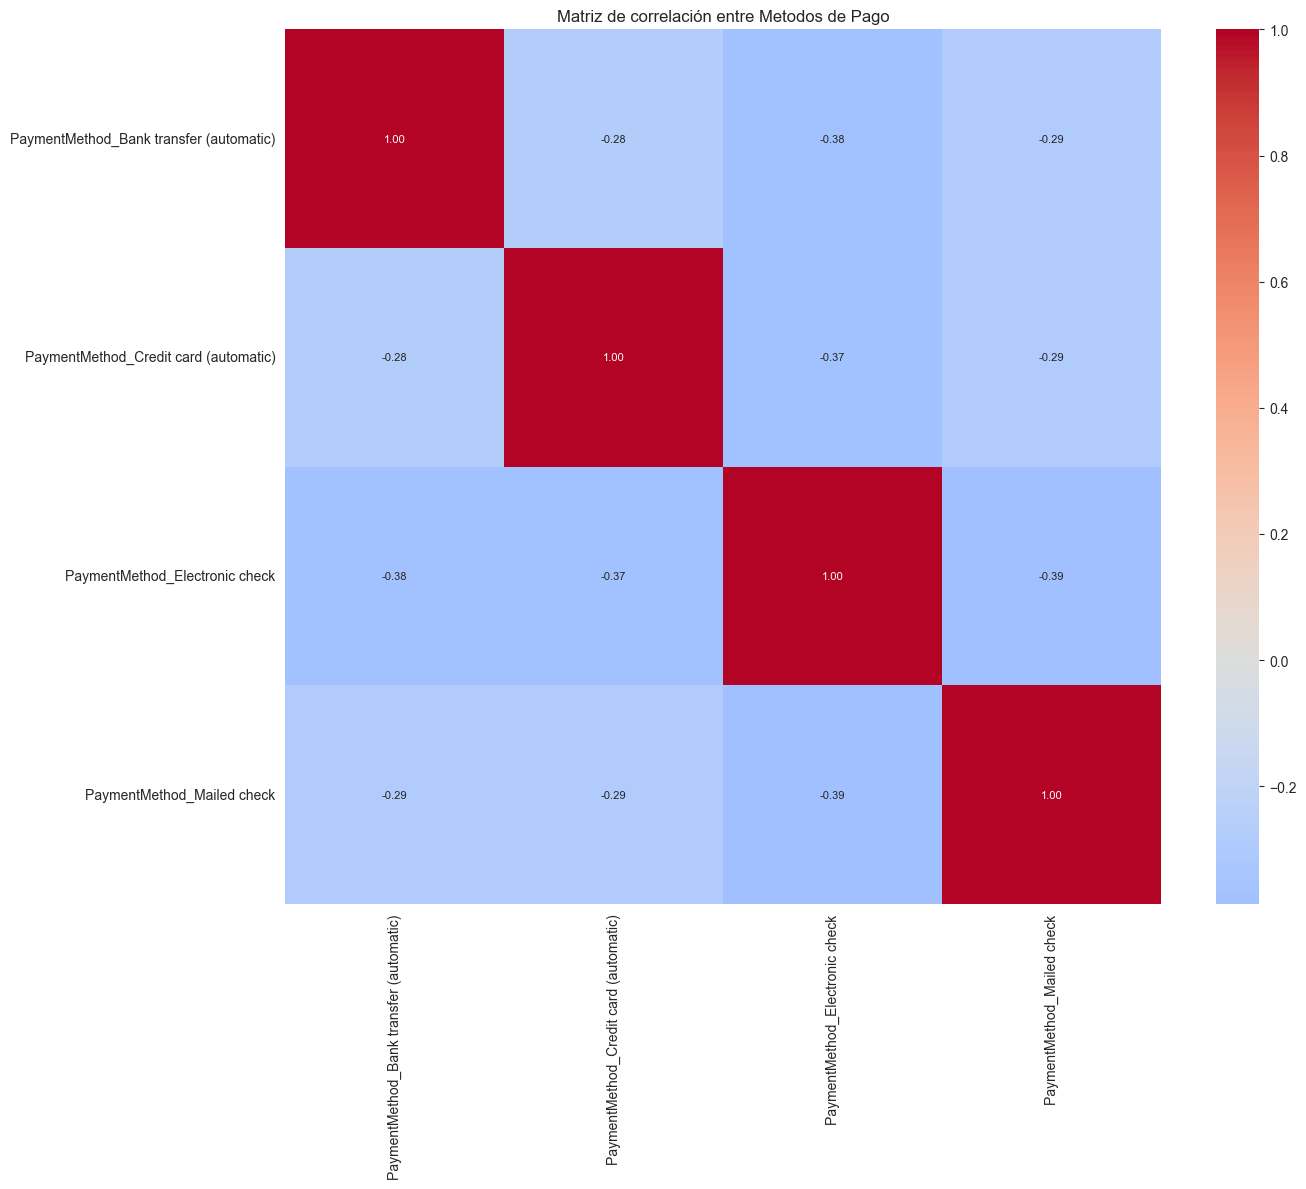

In [17]:
# Matriz de correlación
corr_services = X.corr()

# Heatmap con valores
plt.figure(figsize=(14,12))
sns.heatmap(
    corr_services,
    annot=True,         
    fmt=".2f",         
    cmap="coolwarm",
    center=0,
    cbar=True,
    annot_kws={"size":8} 
)

plt.title("Matriz de correlación entre Metodos de Pago")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

El análisis evidencia que el método de pago influye en el comportamiento de churn. Los clientes que utilizan Electronic check presentan una mayor probabilidad de abandono, 
mientras que aquellos con pagos automáticos,como transferencia bancaria o tarjeta de crédito, muestran una menor tasa de churn.
Esto sugiere que la automatización del pago está asociada con un mayor compromiso y estabilidad del cliente, 
convirtiendo al método de pago en una variable relevante para la predicción del churn.

### INSIGHT 6: -El Dataset presenta un desbalance

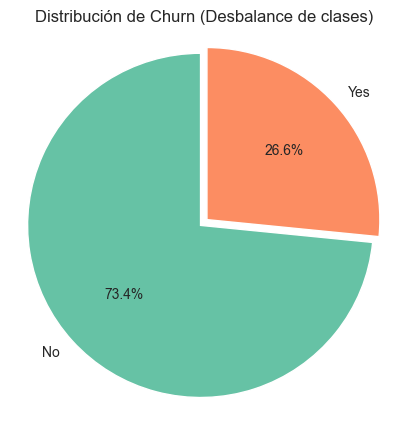

In [18]:
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(
    churn_counts,
    labels=churn_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=[0, 0.05]
)

plt.title('Distribución de Churn (Desbalance de clases)')
plt.axis('equal')  # Hace el pastel circular
plt.show()

La distribución de la variable objetivo muestra un desbalance moderado de clases, donde la mayoría de los clientes no abandona, 
Aunque el churn representa una proporción menor, su presencia es significativa

### Seleccion de Variables 

C:\Users\casti\AppData\Local\Temp\ipykernel_21984\2473440976.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


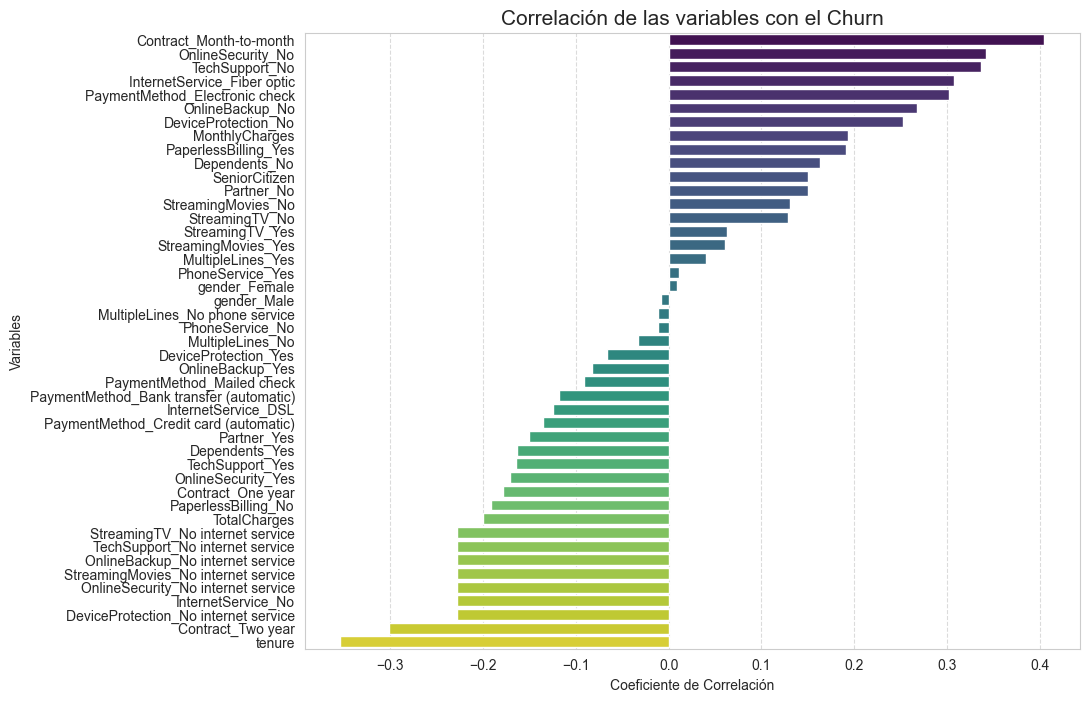

In [19]:
df = df.drop([ 'customerID'], axis=1)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
        'InternetService', 'OnlineSecurity','Contract' ,'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod', 'PaperlessBilling']

df_encoded = pd.get_dummies(
    df, 
    columns=cols,  # Sin los corchetes adicionales []
    drop_first=False
).astype(int)


correlations = df_encoded.corr()['Churn'].sort_values(ascending=False)


correlations = correlations.drop('Churn')

plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')

plt.title('Correlación de las variables con el Churn', fontsize=15)
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [20]:
corr_matrix = df_encoded.corr()['Churn'].abs().sort_values(ascending=False)

umbral = 0.05

variables_basura = correlations[correlations.abs() < umbral].index.tolist()

print(f"Variables identificadas como basura: {variables_basura}")

Variables identificadas como basura: ['MultipleLines_Yes', 'PhoneService_Yes', 'gender_Female', 'gender_Male', 'MultipleLines_No phone service', 'PhoneService_No', 'MultipleLines_No']


In [21]:
X = df_encoded.drop(['Churn'], axis=1, errors='ignore')
if 'customerID' in X.columns:
    X = X.drop('customerID', axis=1)

y = df_encoded['Churn']



In [22]:

df_limpio=df_encoded

In [23]:
### Dataset a Utilizar en el modelo es el df_limpio

df_limpio.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,PaperlessBilling_Yes
0,0,1,29,29,0,1,0,0,1,1,...,0,1,0,0,0,0,1,0,0,1
1,0,34,56,1889,0,0,1,1,0,1,...,0,1,0,0,0,0,0,1,1,0
2,0,2,53,108,1,0,1,1,0,1,...,0,1,0,0,0,0,0,1,0,1
3,0,45,42,1840,0,0,1,1,0,1,...,0,1,0,0,1,0,0,0,1,0
4,0,2,70,151,1,1,0,1,0,1,...,0,1,0,0,0,0,1,0,0,1


## 2. Modelado

In [24]:

target = "Churn"

X = df_limpio.drop(columns=[target])
y = df_limpio[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [25]:
models = {}

### 2.1 Regresión Logistica

In [26]:
# ESPACIO DE HIPERPARÁMETROS
param_grid_logit = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid_logit = GridSearchCV(
    LogisticRegression(max_iter=2000, class_weight="balanced"),
    param_grid_logit,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_logit.fit(X_train, y_train)

print("Mejores parámetros (Logística):", grid_logit.best_params_)
print("Mejor ROC-AUC CV:", grid_logit.best_score_)

models["Logística"] = grid_logit.best_estimator_


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros (Logística): {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor ROC-AUC CV: 0.8469807220061188


### 2.2 Modelos regularizados (clasificación)

#### 2.2.1 Ridge

In [27]:
# ESPACIO DE HIPERPARÁMETROS
param_grid_ridge = {
    "alpha": [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(
    Ridge(),
    param_grid_ridge,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_ridge.fit(X_train, y_train)

print("Mejores parámetros (Ridge):", grid_ridge.best_params_)
print("Mejor ROC-AUC CV:", grid_ridge.best_score_)

models["Ridge"] = grid_ridge.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores parámetros (Ridge): {'alpha': 0.01}
Mejor ROC-AUC CV: nan


c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


#### 2.2.2 Lasso

In [28]:
# ESPACIO DE HIPERPARÁMETROS
param_grid_lasso = {
    "alpha": [0.0001, 0.001, 0.01, 0.1]
}

grid_lasso = GridSearchCV(
    Lasso(max_iter=5000),
    param_grid_lasso,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_lasso.fit(X_train, y_train)

print("Mejores parámetros (Lasso):", grid_lasso.best_params_)
print("Mejor ROC-AUC CV:", grid_lasso.best_score_)

models["Lasso"] = grid_lasso.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros (Lasso): {'alpha': 0.0001}
Mejor ROC-AUC CV: nan


c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


#### 2.2.3 Elastic Net

In [29]:

# ESPACIO DE HIPERPARÁMETROS
param_grid_elastic = {
    "alpha": [0.0001, 0.001, 0.01],
    "l1_ratio": [0.2, 0.5, 0.8]
}

grid_elastic = GridSearchCV(
    ElasticNet(max_iter=5000),
    param_grid_elastic,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_elastic.fit(X_train, y_train)

print("Mejores parámetros (Elastic Net):", grid_elastic.best_params_)
print("Mejor ROC-AUC CV:", grid_elastic.best_score_)

models["Elastic Net"] = grid_elastic.best_estimator_


Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejores parámetros (Elastic Net): {'alpha': 0.0001, 'l1_ratio': 0.2}
Mejor ROC-AUC CV: nan


c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+02, tolerance: 9.604e-02
  model = cd_fast.enet_coordinate_descent(


### 2.3 SGDClassifier

In [30]:
# ESPACIO DE HIPERPARÁMETROS
param_grid_sgd = {
    "alpha": [0.0001, 0.001, 0.01],
    "penalty": ["l2", "l1", "elasticnet"]
}

grid_sgd = GridSearchCV(
    SGDClassifier(
        loss="log_loss",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ),
    param_grid_sgd,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_sgd.fit(X_train, y_train)

print("Mejores parámetros (SGD):", grid_sgd.best_params_)
print("Mejor ROC-AUC CV:", grid_sgd.best_score_)

models["SGD"] = grid_sgd.best_estimator_


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Mejores parámetros (SGD): {'alpha': 0.0001, 'penalty': 'l1'}
Mejor ROC-AUC CV: 0.7650641088471027


### 2.4 LDA

In [31]:
# ESPACIO DE HIPERPARÁMETROS
param_grid_lda = {
    'solver': ['lsqr', 'eigen'],  
    'shrinkage': ['auto', 0.2, 0.5, 0.8]  
}

# GridSearchCV para LDA
grid_lda = GridSearchCV(
    LinearDiscriminantAnalysis(),
    param_grid_lda,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_lda.fit(X_train, y_train)

print(f"\nMejores parámetros (LDA): {grid_lda.best_params_}")
print(f"Mejor ROC-AUC (CV) (LDA): {grid_lda.best_score_:.4f}")

models["LDA"] = grid_lda.best_estimator_

Fitting 4 folds for each of 8 candidates, totalling 32 fits

Mejores parámetros (LDA): {'shrinkage': 'auto', 'solver': 'lsqr'}
Mejor ROC-AUC (CV) (LDA): 0.8391


### 2.5 SVM

In [32]:

# ESPACIO DE HIPERPARÁMETROS
param_grid_svm = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.1],
    "kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    SVC(
        probability=True,
        class_weight="balanced"
    ),
    param_grid_svm,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)

print("Mejores parámetros (SVM):", grid_svm.best_params_)
print("Mejor ROC-AUC CV:", grid_svm.best_score_)

models["SVM"] = grid_svm.best_estimator_


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Mejores parámetros (SVM): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor ROC-AUC CV: 0.788839078750235


### 2.6 KNN

In [33]:

# Configuración de hiperparámetros para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Número de vecinos (k)
    'weights': ['uniform', 'distance'],  # Peso de los votos
    'metric': ['euclidean', 'manhattan']  # Distancia para medir proximidad
}

# GridSearchCV para KNN
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)  # KNN ES MUY sensible a la escala

print(f"\nMejores parámetros (KNN): {grid_knn.best_params_}")
print(f"Mejor ROC-AUC (CV) (KNN): {grid_knn.best_score_:.4f}")

models["KNN"] = grid_knn.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros (KNN): {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Mejor ROC-AUC (CV) (KNN): 0.7956


### 2.7 Naïve Bayes

In [34]:
# ESPACIO DE HIPERPARÁMETROS
param_grid_nb = {
    "var_smoothing": [1e-12, 1e-10, 1e-9, 1e-8, 1e-7]
}

# MODELO BASE
grid_nb = GridSearchCV(
    GaussianNB(),
    param_grid_nb,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_nb.fit(X_train, y_train)

print("Mejores parámetros (Naive Bayes):", grid_nb.best_params_)
print("Mejor ROC-AUC CV:", grid_nb.best_score_)

models["Naive Bayes"] = grid_nb.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores parámetros (Naive Bayes): {'var_smoothing': 1e-07}
Mejor ROC-AUC CV: 0.8249898191076758


### 2.8 Árboles de Decisión

In [35]:
def plot_confusion_matrix(
    model,
    X,
    y_true,
    labels=("No Churn", "Churn"),
    threshold=None,
    title=None
):
    """
    Plots confusion matrix for any classifier.
    
    Parameters:
    - model: trained model (sklearn, xgboost, etc.)
    - X: features
    - y_true: true labels
    - labels: class names
    - threshold: custom probability threshold (optional)
    - title: plot title (optional)
    """

    # Predictions
    if threshold is not None and hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )

    disp.plot(cmap="Blues", values_format="d")
    plt.title(title if title else "Confusion Matrix")
    plt.show()

    return cm


Best parameters:
 {'splitter': 'random', 'min_samples_leaf': 50, 'max_features': None, 'max_depth': 10, 'criterion': 'gini', 'class_weight': None}

Train classification report:

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3614
           1       0.67      0.54      0.60      1308

    accuracy                           0.81      4922
   macro avg       0.76      0.72      0.74      4922
weighted avg       0.80      0.81      0.80      4922


Test classification report:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.64      0.48      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.71      2110
weighted avg       0.78      0.79      0.78      2110

Contract_Month-to-month        0.496951
InternetService_Fiber optic    0.168692
tenure                         0.152822
TechSupport_No    

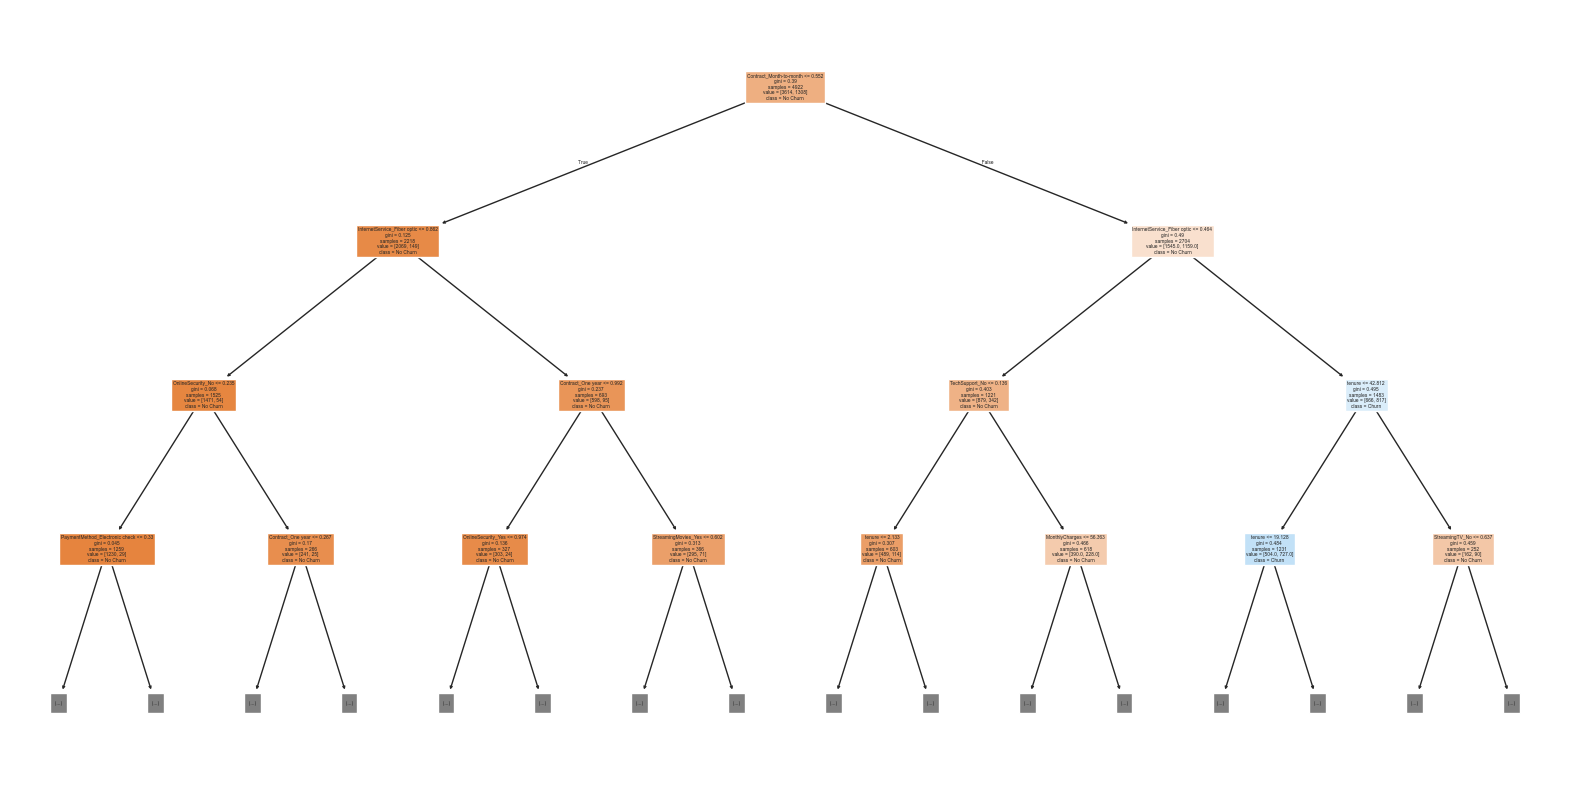

In [36]:

cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns


ohe = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])

X_train_enc = np.hstack([
    X_train[num_cols].values,
    X_train_cat
])

X_test_enc = np.hstack([
    X_test[num_cols].values,
    X_test_cat
])

feature_names = (
    list(num_cols) +
    list(ohe.get_feature_names_out(cat_cols))
)

# =========================
#  HIPERPARÁMETROS
# =========================
param_dist = {
    "max_depth": range(2, 15),
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 5, 10, 20, 50],
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "class_weight": ["balanced", None]
}

# =========================
# RANDOMIZED SEARCH
# =========================
search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_enc, y_train)

best_tree = search.best_estimator_


# =========================
# EVALUACIÓN
# =========================
print("Best parameters:\n", search.best_params_)
print("\nTrain classification report:\n")
print(classification_report(y_train, best_tree.predict(X_train_enc)))

print("\nTest classification report:\n")
print(classification_report(y_test, best_tree.predict(X_test_enc)))


# =========================
# FEATURE IMPORTANCE
# =========================
importances = pd.Series(
    best_tree.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print(importances.head(10))




plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=feature_names,
    class_names=["No Churn", "Churn"],
    filled=True,
    max_depth=3
)
plt.show()

models["Decision Tree"] = best_tree


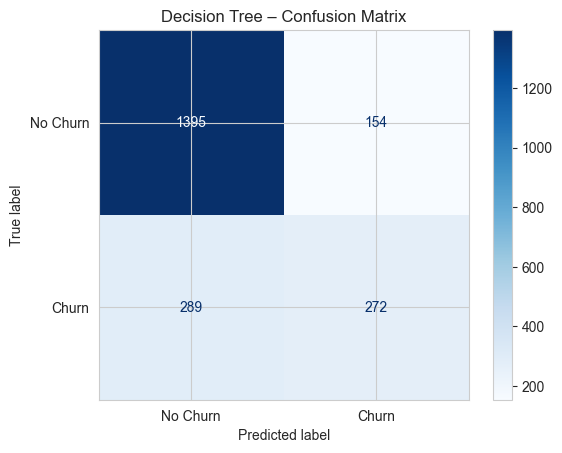

array([[1395,  154],
       [ 289,  272]], dtype=int64)

In [37]:
plot_confusion_matrix(
    model=best_tree,
    X=X_test_enc,
    y_true=y_test,
    title="Decision Tree – Confusion Matrix"
)

### 2.9 Redes Neuronales (MLPClassifier)

In [38]:
# ESPACIO DE HIPERPARÁMETROS
param_grid_mlp = {
    "hidden_layer_sizes": [(50,), (50, 25), (100,)],
    "alpha": [0.0001, 0.001, 0.01]
}
# MODELO BASE
grid_mlp = GridSearchCV(
    MLPClassifier(
        max_iter=2000,
        random_state=42
    ),
    param_grid_mlp,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_mlp.fit(X_train, y_train)

print("Mejores parámetros (MLP):", grid_mlp.best_params_)
print("Mejor ROC-AUC CV:", grid_mlp.best_score_)

models["MLP"] = grid_mlp.best_estimator_


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Mejores parámetros (MLP): {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Mejor ROC-AUC CV: 0.8311433396075453


### 2.10 Modelos de Ensamble (clasificación)

#### 2.10.1 Random Forest

In [39]:
# ESPACIO DE HIPERPARÁMETROS
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced", None]
}

# MODELO BASE
search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    random_state=42
)

search_rf.fit(X_train_enc, y_train)

best_rf = search_rf.best_estimator_

print("Best parameters:\n", search_rf.best_params_)

print("\nTrain classification report:\n")
print(classification_report(y_train, best_rf.predict(X_train_enc)))

print("\nTest classification report:\n")
print(classification_report(y_test, best_rf.predict(X_test_enc)))

# Feature importance (top 10)
importances = pd.Series(
    best_rf.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print("\nTop 10 feature importances:\n")
print(importances.head(10))

models["Random Forest"] = best_rf

Best parameters:
 {'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced'}

Train classification report:

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      3614
           1       0.59      0.84      0.70      1308

    accuracy                           0.81      4922
   macro avg       0.76      0.82      0.78      4922
weighted avg       0.84      0.81      0.81      4922


Test classification report:

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1549
           1       0.53      0.77      0.63       561

    accuracy                           0.76      2110
   macro avg       0.72      0.76      0.73      2110
weighted avg       0.80      0.76      0.77      2110


Top 10 feature importances:

tenure                            0.136437
Contract_Month-to-month           0.128068
TotalCharges                      0.

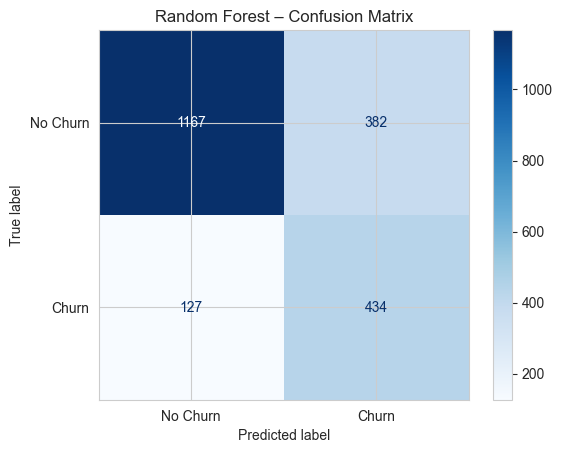

array([[1167,  382],
       [ 127,  434]], dtype=int64)

In [40]:
plot_confusion_matrix(
    model=best_rf,
    X=X_test_enc,
    y_true=y_test,
    title="Random Forest – Confusion Matrix"
)


#### 2.10.2 Gradient Boosting

In [41]:
# ESPACIO DE HIPERPARÁMETROS
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 5, 10, 20],
    "subsample": [0.6, 0.8, 1.0]
}

# MODELO BASE
search_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",   
    cv=5,
    n_jobs=-1,
    random_state=42
)

search_gb.fit(X_train_enc, y_train)

best_gb = search_gb.best_estimator_


print("Best parameters:\n", search_gb.best_params_)

print("\nTrain classification report:\n")
print(classification_report(y_train, best_gb.predict(X_train_enc)))

print("\nTest classification report:\n")
print(classification_report(y_test, best_gb.predict(X_test_enc)))

models["Gradient Boosting"] = best_gb

Best parameters:
 {'subsample': 0.8, 'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': 2, 'learning_rate': 0.05}

Train classification report:

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3614
           1       0.70      0.56      0.62      1308

    accuracy                           0.82      4922
   macro avg       0.77      0.74      0.75      4922
weighted avg       0.81      0.82      0.81      4922


Test classification report:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.64      0.50      0.56       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110



In [42]:
importances = pd.Series(
    best_gb.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print(importances.head(10))


Contract_Month-to-month           0.311036
tenure                            0.216774
InternetService_Fiber optic       0.116734
OnlineSecurity_No                 0.094092
TechSupport_No                    0.056933
MonthlyCharges                    0.044212
PaymentMethod_Electronic check    0.043234
TotalCharges                      0.035530
MultipleLines_No                  0.014834
OnlineBackup_No                   0.009485
dtype: float64


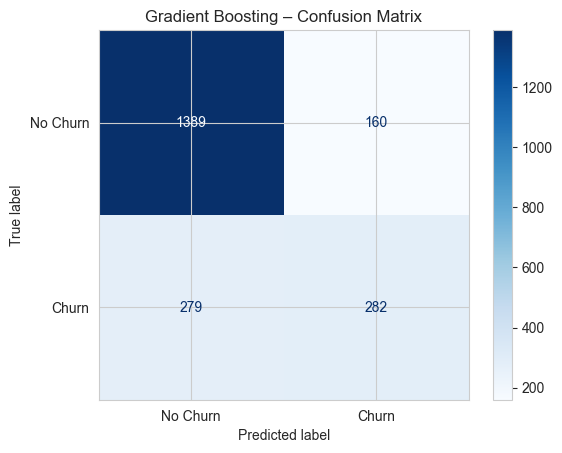

array([[1389,  160],
       [ 279,  282]], dtype=int64)

In [43]:
plot_confusion_matrix(best_gb, X_test_enc, y_test, title="Gradient Boosting – Confusion Matrix")

#### 2.10.3 XGBoost

In [44]:

# 2. ESPACIO DE HIPERPARÁMETROS
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3, 1],
    "min_child_weight": [1, 3, 5]
}

# 3. MODELO BASE
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# 4. RANDOMIZED SEARCH
search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",  
    cv=5,
    n_jobs=-1,
    random_state=42
)

# 5. ENTRENAMIENTO
search_xgb.fit(X_train_enc, y_train)

# 6. MEJOR MODELO
best_xgb = search_xgb.best_estimator_

print("Best parameters:")
print(search_xgb.best_params_)

# 7. EVALUACIÓN
print("\nTrain classification report:\n")
print(classification_report(y_train, best_xgb.predict(X_train_enc)))

print("\nTest classification report:\n")
print(classification_report(y_test, best_xgb.predict(X_test_enc)))

models["XGBoost"] = best_xgb



c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters:
{'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

Train classification report:

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3614
           1       0.71      0.55      0.62      1308

    accuracy                           0.82      4922
   macro avg       0.78      0.73      0.75      4922
weighted avg       0.81      0.82      0.81      4922


Test classification report:

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1549
           1       0.66      0.50      0.57       561

    accuracy                           0.80      2110
   macro avg       0.74      0.70      0.72      2110
weighted avg       0.79      0.80      0.79      2110



c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:47:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


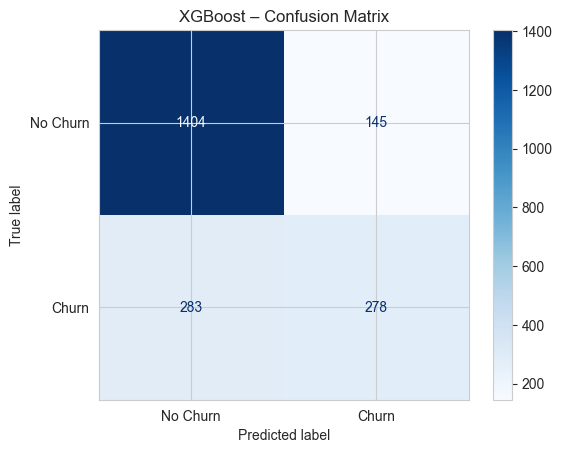

array([[1404,  145],
       [ 283,  278]], dtype=int64)

In [45]:

plot_confusion_matrix(
    model=best_xgb,
    X=X_test_enc,
    y_true=y_test,
    title="XGBoost – Confusion Matrix"
)

#### 2.10.12AdaBoost

In [46]:
# ESPACIO DE HIPERPARÁMETROS
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0]
}

search_ada = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_grid=param_dist,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

search_ada.fit(X_train_enc, y_train)
best_ada = search_ada.best_estimator_

print("Best parameters:\n", search_ada.best_params_)
print("\nTrain classification report:\n")
print(classification_report(y_train, best_ada.predict(X_train_enc)))

print("\nTest classification report:\n")
print(classification_report(y_test, best_ada.predict(X_test_enc)))

models["AdaBoost"] = best_ada


Best parameters:
 {'learning_rate': 0.5, 'n_estimators': 200}

Train classification report:

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      3614
           1       0.67      0.56      0.61      1308

    accuracy                           0.81      4922
   macro avg       0.76      0.73      0.74      4922
weighted avg       0.80      0.81      0.81      4922


Test classification report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.63      0.52      0.57       561

    accuracy                           0.79      2110
   macro avg       0.73      0.71      0.72      2110
weighted avg       0.78      0.79      0.79      2110



In [47]:

importances = pd.Series(
    best_ada.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print(importances.head(10))




tenure                            0.303812
Contract_Month-to-month           0.182370
OnlineSecurity_No                 0.107301
MonthlyCharges                    0.078141
InternetService_Fiber optic       0.064577
Contract_Two year                 0.063103
TechSupport_No                    0.061804
PaymentMethod_Electronic check    0.029170
MultipleLines_No                  0.022038
StreamingMovies_Yes               0.015490
dtype: float64


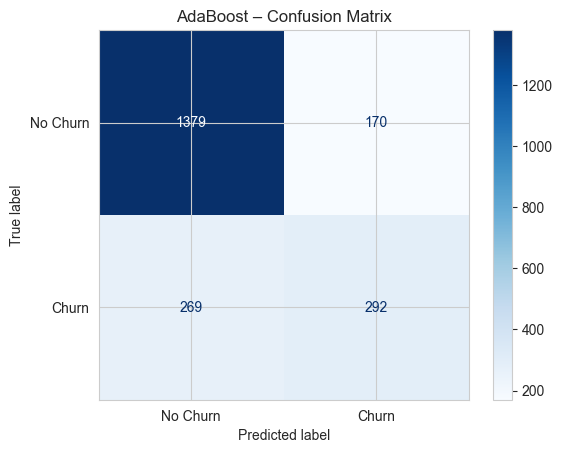

array([[1379,  170],
       [ 269,  292]], dtype=int64)

In [48]:
plot_confusion_matrix(
    model=best_ada,
    X=X_test_enc,
    y_true=y_test,
    title="AdaBoost – Confusion Matrix"
)


## 3. Evaluación train vs test

In [49]:

results = []

for name, model in models.items():

    # TRAIN
    if name in ["Ridge", "Lasso", "Elastic Net"]:
        y_score_train = model.predict(X_train)
        y_pred_train = (y_score_train >= 0.5).astype(int)
        y_proba_train = y_score_train
    else:
        y_pred_train = model.predict(X_train)
        y_proba_train = model.predict_proba(X_train)[:, 1]

    roc_train = roc_auc_score(y_train, y_proba_train)
    f1_train = f1_score(y_train, y_pred_train)

    # TEST
    if name in ["Ridge", "Lasso", "Elastic Net"]:
        y_score_test = model.predict(X_test)
        y_pred_test = (y_score_test >= 0.5).astype(int)
        y_proba_test = y_score_test
    else:
        y_pred_test = model.predict(X_test)
        y_proba_test = model.predict_proba(X_test)[:, 1]

    roc_test = roc_auc_score(y_test, y_proba_test)
    f1_test = f1_score(y_test, y_pred_test)

    results.append((
        name,
        roc_train, f1_train,
        roc_test, f1_test
    ))


c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\casti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has fe

In [50]:
# Tabla train vs test
df_results = pd.DataFrame(
    results,
    columns=[
        "Modelo",
        "ROC_AUC_Train", "F1_Train",
        "ROC_AUC_Test", "F1_Test"
    ]
)

df_results.sort_values("ROC_AUC_Test", ascending=False)



,Modelo,ROC_AUC_Train,F1_Train,ROC_AUC_Test,F1_Test
12,Gradient Boosting,0.866274,0.621770,0.841176,0.562313
13,XGBoost,0.868610,0.619416,0.841130,0.565041
11,Random Forest,0.898703,0.696038,0.839133,0.630356
0,Logística,0.851668,0.636828,0.838023,0.615811
14,AdaBoost,0.856862,0.614553,0.837795,0.570870
2,Lasso,0.842614,0.581943,0.832143,0.573689
5,LDA,0.842729,0.597551,0.832017,0.599251
3,Elastic Net,0.842693,0.580479,0.831837,0.575099
1,Ridge,0.842764,0.581585,0.831647,0.573689
9,Decision Tree,0.858293,0.601777,0.828245,0.551165


##### Se observa que los modelos de ensamble, particularmente Random Forest, ofrecen el mejor equilibrio entre capacidad de discriminación y desempeño de clasificación, al presentar uno de los valores más altos de ROC-AUC y el mayor F1-score en el conjunto de prueba,es decir, clasifica mejor los casos positivos sin disparar falsos positivos. Esto indica que Random Forest no solo separa bien las clases, sino que también toma decisiones de clasificación más efectivas. No obstante, modelos más simples como la regresión logística y el MLP alcanzan resultados comparables, lo que sugiere que gran parte de la estructura del problema puede modelarse adecuadamente sin necesidad de una complejidad excesiva.